<a href="https://colab.research.google.com/github/FlyingWorkshop/DiffusionGNNTutorial/blob/main/simple_edm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric
!pip install rdkit

Data(x=[16, 11], edge_index=[2, 40], edge_attr=[40, 4], y=[1, 19], pos=[16, 3], z=[16], smiles='[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14O[C@@]1([H])[C@@]([H])([C@]24[H])[C@]13[H]', name='gdb_133885', idx=[1])


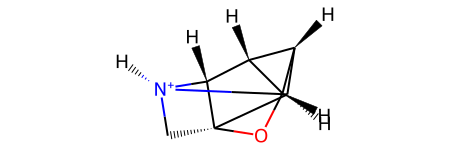

In [2]:
from torch_geometric.datasets import QM9
from rdkit import Chem


# load QM9 dataset
# documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html?highlight=qm9#torch_geometric.datasets.QM9
dataset = QM9(root='drive/MyDrive/Tutorial/data/QM9/')
ex_hard = dataset[-1]
print(ex_hard)
mol = Chem.MolFromSmiles(ex_hard.smiles)
mol

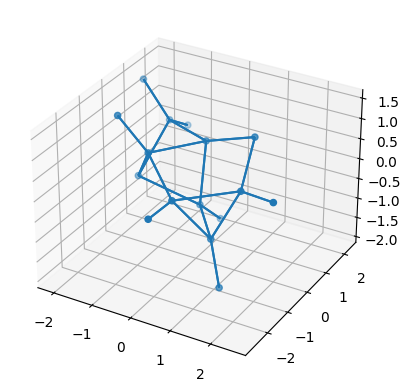

In [6]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt
import torch


def plot_molecule(example):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # draw nodes
  pos = example.pos
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

  # draw edges
  edge_index = example.edge_index
  starts = pos[edge_index[0]]
  stops = pos[edge_index[1]]
  lines = torch.hstack((starts, stops)).reshape((-1, 2, 3))
  ax.add_collection(Line3DCollection(lines))

plot_molecule(ex_hard)

In [7]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.spatial.transform import Rotation
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
class SimpleEGCL(nn.Module):
  def __init__(self, hidden=32):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(1, hidden),
        nn.SiLU(),
        nn.Linear(hidden, 1)
    )

  def forward(self, noised_pos):
    diffs = noised_pos - noised_pos.unsqueeze(1)
    dists = torch.norm(diffs, dim=-1, keepdim=True)
    normalized = diffs / (dists + 1)
    batched_dists = dists.ravel().unsqueeze(-1)
    weights = self.mlp(batched_dists).reshape_as(dists)
    pred_noise = torch.sum(normalized * weights, dim=0)  # TODO: figure out if dim 0 or 1
    pred_pos = noised_pos - pred_noise
    return pred_pos, pred_noise


class SimpleEGNN(nn.Module):
  def __init__(self, num_layers: int = 1):
    super().__init__()
    self.layers = nn.ModuleList([SimpleEGCL() for _ in range(num_layers)])

  def forward(self, pos):
    for layer in self.layers:
      pos = layer(pos)
    return pos


class SimpleEDM:
  def __init__(self, max_timesteps: int = 1000, lr=1e-3):
    self.model = SimpleEGNN()
    self.loss_fn = nn.MSELoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    self.max_timesteps = max_timesteps
    self.normal_dist = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))
    self.uniform_dist = torch.distributions.Uniform(low=0, high=max_timesteps)

  def alpha(self, t):
    return np.sqrt(1 - self.sigma(t))

  def sigma(self, t):
    return 0.005

  def plot_alpha_and_sigma():
    pass

  def sample_noise(self, n):
    noise = self.normal_dist.sample(sample_shape=(n,))  # noise.shape = (n, 3)
    noise -= torch.mean(noise, dim=0, keepdim=True)
    return noise

  def _optimize_step(self, pos, t):
    self.optimizer.zero_grad()
    n = pos.shape[0]
    noise = self.sample_noise(n)
    noised_pos = self.alpha(t) * pos + self.sigma(t) * noise  # forward step in diffusion process
    pred_pos, pred_noise = self.model(noised_pos)
    loss = self.loss_fn(pred_noise, noise)
    loss.backward()
    self.optimizer.step()

    # postprocess
    loss = loss.detach().numpy()
    pred_pos = pred_pos.detach()
    noised_pos = noised_pos.detach()
    return loss, pred_pos, pred_noise, noised_pos

  def optimize(self, example, verbose=False):
    history = {"loss": [], "pred_pos": [], "true_pos": []}

    pos = example.pos
    for t in range(self.max_timesteps):
      loss, pred_pos, pred_noise, noised_pos = self._optimize_step(pos, t)

      history["loss"].append(loss)
      history["pred_pos"].append(pred_pos)
      history["true_pos"].append(pos)
      pos = noised_pos

      if verbose:
        print(f"{t}: {loss}")

    return history

Text(0, 0.5, 'MSE')

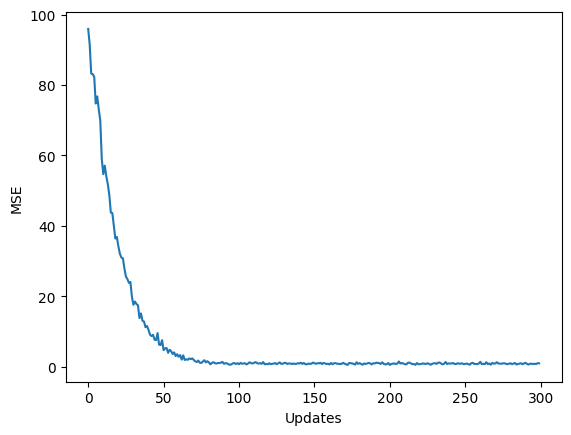

In [34]:
edm = SimpleEDM(max_timesteps=300)
history = edm.optimize(ex_hard, verbose=False)

plt.plot(range(len(history["loss"])), history["loss"])
plt.xlabel("Updates")
plt.ylabel("MSE")

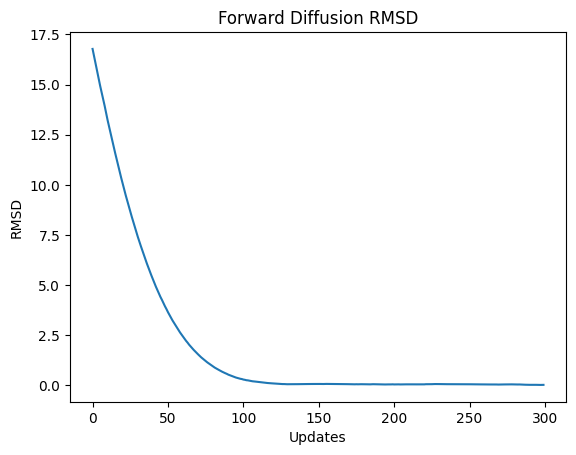

In [38]:
def calc_rmsd(coords_a: torch.Tensor, coords_b: torch.Tensor) -> torch.Tensor:
    """
    From Martin Buttenschoen.
    Calculate RMSD assuming that the atom positions are ordered appropriately.
    """
    assert coords_a.shape == coords_b.shape
    return (((coords_a - coords_b) ** 2).mean() * coords_a.shape[-1]).sqrt()

def plot_rmsd(history):
  rmsd_history = []
  for true_pos, pred_pos in zip(history["true_pos"], history["pred_pos"]):
    rmsd = calc_rmsd(true_pos, pred_pos)
    rmsd_history.append(rmsd)
  plt.plot(range(len(rmsd_history)), rmsd_history)
  plt.xlabel("Updates")
  plt.ylabel("RMSD")
  plt.title("Forward Diffusion RMSD")

plot_rmsd(history)

In [39]:
from tqdm.auto import tqdm
from PIL import Image
from IPython.display import HTML
import io


def fig2img(fig):
    """
    Adapted from: https://stackoverflow.com/a/61754995/15001799
    Convert a Matplotlib figure to a PIL Image and return it
    """
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def animate_forward_diffusion(example, history, save_path="drive/MyDrive/Tutorial/forward_diffusion.gif"):
  frames = []

  edge_index = example.edge_index

  for i, (true_pos, pred_pos) in tqdm(enumerate(zip(history["true_pos"], history["pred_pos"])), total=len(history["true_pos"])):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.set_xlim(-3, 3)
    # ax.set_ylim(-3, 3)
    # ax.set_zlim(-3, 3)

    for j, pos in enumerate([true_pos, pred_pos]):
      # draw nodes
      ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=f"C{j}")

      # draw edges
      starts = pos[edge_index[0]]
      stops = pos[edge_index[1]]
      lines = torch.hstack((starts, stops)).reshape((-1, 2, 3))
      ax.add_collection(Line3DCollection(lines, color=f"C{j}"))

    fig.savefig("f")
    frames.append(fig2img(fig))
    plt.close()

  frames[0].save(save_path, save_all=True, append_images=frames[1:], duration=60, loop=0, optimize=True, quality=20)

animate_forward_diffusion(ex_hard, history)

  0%|          | 0/300 [00:00<?, ?it/s]